<a href="https://colab.research.google.com/github/dvschultz/stylegan2-ada-pytorch/blob/main/SG2-ADA-PT_AudioReactive%2BPitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#StyleGAN2 Reactive Audio

By Derrick Schultz for the StyleGAN2 Deep Dive class.

This notebook shows one basic example of how to alter your StyleGAN2 vectors with audio. There are lots of different techniques to explore in this, but this is one simple way.

Big thanks to Robert Luxemburg who provided the basis for a lot of this code with [this gist](https://gist.github.com/rolux/48f1da6cf2bc6ca5833dbacbf852b348).

##Installation

First let’s install the repos and dependencies needed.

In [ ]:
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-769fd161-d896-0474-0c9d-83a26fc88732)


In [ ]:
# Derrick's repo (even if you trained with skyflynil this will work!)
!git clone https://github.com/dvschultz/stylegan2-ada-pytorch #use this fork to get interpolation functions
!pip install ninja opensimplex # needed for noise interpolation
%cd stylegan2-ada-pytorch

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 255 (delta 4), reused 4 (delta 2), pack-reused 246
Receiving objects: 100% (255/255), 1.18 MiB | 13.54 MiB/s, done.
Resolving deltas: 100% (131/131), done.
     |████████████████████████████████| 112kB 13.4MB/s 
/content/stylegan2-ada-pytorch


### Import a .pkl file here

You can either upload one or use gdown to import one from Google Drive

In [ ]:
!gdown --id 1K7mgdzdQwOERoyft95eFg1-5Tj4XcMAc -O /content/freagan.pkl

Downloading...
From: https://drive.google.com/uc?id=1K7mgdzdQwOERoyft95eFg1-5Tj4XcMAc
To: /content/freagan.pkl
382MB [00:03, 110MB/s]


## Upload an audio file

I recommend uploading something simple to start with (think a single instrument or track with silence in it). The file should be in .mp3 or .wav format.

In [ ]:
from google.colab import files

uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

Saving rushing-back-clip.wav to rushing-back-clip.wav


##Process audio
The next step process our audio files. Edit the first line of the next cell to point to your audio file. The run the cell after that to process the audio and generate a graph of the volume data.

In [ ]:
# make sure you are pointing to your audio file
wav_filename = '/content/test.wav'
# set th framerat for your video output
fps = 24


Run this cell to process the audio file (you don’t need to edit anything).

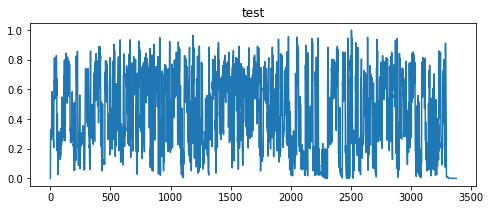

In [ ]:
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import wavfile
import matplotlib.pyplot as plt
import PIL.Image
import moviepy.editor

# import dnnlib
# import dnnlib.tflib as tflib
# import pickle
# import pretrained_networks

audio = {}

if not os.path.exists(wav_filename):
    audio_clip = moviepy.editor.AudioFileClip(wav_filename)
    audio_clip.write_audiofile(wav_filename, fps=44100, nbytes=2, codec='pcm_s16le')
track_name = os.path.basename(wav_filename)[:-4]
rate, signal = wavfile.read(wav_filename)
signal = np.mean(signal, axis=1) # to mono
signal = np.abs(signal)
# seed = signal.shape[0]
duration = signal.shape[0] / rate
frames = int(np.ceil(duration * fps))
samples_per_frame = signal.shape[0] / frames
audio[track_name] = np.zeros(frames, dtype=signal.dtype)
for frame in range(frames):
    start = int(round(frame * samples_per_frame))
    stop = int(round((frame + 1) * samples_per_frame))
    audio[track_name][frame] = np.mean(signal[start:stop], axis=0)
audio[track_name] /= max(audio[track_name])

for track in sorted(audio.keys()):
    plt.figure(figsize=(8, 3))
    plt.title(track)
    plt.plot(audio[track])
    plt.savefig(f'../{track}.png')

Run the next cell to define some functions we’ll need to use to generate our inference images.

In [ ]:
import dnnlib
import numpy as np
import torch
import PIL.Image
import legacy


def line_interpolate(zs, steps, easing):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            t = index/float(steps)

            if(easing == 'linear'):
                out.append(zs[i+1]*t + zs[i]*(1-t))
            elif (easing == 'easeInOutQuad'):
                if(t < 0.5):
                    fr = 2 * t * t
                else:
                    fr = (-2 * t * t) + (4 * t) - 1
                out.append(zs[i+1]*fr + zs[i]*(1-fr))
            elif (easing == 'bounceEaseOut'):
                if (t < 4/11):
                    fr = 121 * t * t / 16
                elif (t < 8/11):
                    fr = (363 / 40.0 * t * t) - (99 / 10.0 * t) + 17 / 5.0
                elif t < 9/ 0:
                    fr = (4356 / 361.0 * t * t) - (35442 / 1805.0 * t) + 16061 / 1805.0
                else:
                    fr = (54 / 5.0 * t * t) - (513 / 25.0 * t) + 268 / 25.0
                out.append(zs[i+1]*fr + zs[i]*(1-fr))
            elif (easing == 'circularEaseOut'):
                fr = np.sqrt((2 - t) * t)
                out.append(zs[i+1]*fr + zs[i]*(1-fr))
            elif (easing == 'circularEaseOut2'):
                fr = np.sqrt(np.sqrt((2 - t) * t))
                out.append(zs[i+1]*fr + zs[i]*(1-fr))
    return out


def images(G,device,inputs,space,truncation_psi,label,noise_mode,outdir,start=None,stop=None):
    if(start is not None and stop is not None):
        tp = start
        tp_i = (stop-start)/len(inputs)

    for idx, i in enumerate(inputs):
        print('Generating image for frame %d/%d ...' % (idx, len(inputs)))
        
        if (space=='z'):
            z = torch.from_numpy(i).to(device)
            if(start is not None and stop is not None):
                img = G(z, label, truncation_psi=tp, noise_mode=noise_mode)
                tp = tp+tp_i
            else:
                img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
        else:
            if i.shape[0] == 18: 
              i = torch.from_numpy(i).unsqueeze(0).to(device)
            img = G.synthesis(i, noise_mode=noise_mode, force_fp32=True)
        img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/frame{idx:04d}.png')

# def lerp(v0, v1, t):
#     # print(t)
#     return v1*t + v0*(1-t)
    

def seeds_to_zs(G,seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        z = np.random.RandomState(seed).randn(1, G.z_dim)
        zs.append(z)
    return zs

def valmap(value, istart, istop, ostart, ostop):
    return ostart + (ostop - ostart) * ((value - istart) / (istop - istart))

def zs_to_ws(G,device,label,truncation_psi,zs):
    ws = []
    for z_idx, z in enumerate(zs):
        z = torch.from_numpy(z).to(device)
        w = G.mapping(z, label, truncation_psi=truncation_psi, truncation_cutoff=8)
        ws.append(w)
    return ws

## Generate Images

### Use Volume to interpolate between two seeds
The next cell will take two seed values and do a linear interpolation of them using the volume from your audio. When the audio is silent, it will be the first seed you list. When it is at its loudest it will be the second. Everything in between will be an interpolated value.

In [ ]:
# set each of these variables
network_pkl = '/content/freagan.pkl'
seeds=[38,11]
truncation_psi = 0.5
outdir = '/content/out/'

# ---------------------------
#you probably won't need to edit anything below this
# ---------------------------
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

os.makedirs(outdir, exist_ok=True)

label = torch.zeros([1, G.c_dim], device=device)


def lerp(v0, v1, t):
    # print(t)
    return v0*(1.0-t)+v1*t


ends = seeds_to_zs(G,seeds)
ends_w = zs_to_ws(G,device,label,truncation_psi,ends)

vectors = []
for f in range(frames):
  vectors.append(lerp(ends_w[0],ends_w[1],audio[track_name][f]))

#generate_images_in_w_space(vectors,truncation_value)

images(G,device,vectors,'w',truncation_psi,label,'const',outdir,start=None,stop=None)


### Combine the frames into a video and add the audio track back to it

There’s probably a cleaner way to do this all in moviepy but I’m being lazy.

In [ ]:
!ffmpeg -r {fps} -i {outdir}frame%04d.png -vcodec libx264 -pix_fmt yuv420p /content/out.mp4

In [ ]:
mp4_filename = '/content/combined.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/out.mp4')
audio_clip_i = moviepy.editor.AudioFileClip(wav_filename)
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='15M')

## Pitch Control

The above video processes volume, but maybe we want to process pitch change?

For this to work correctly I highly recommend you use an audio sample of a single instrument (singing, piano, flute, etc.). Polyphonic sound tends to confuse this model.

In [ ]:
!pip install crepe

Uncomment and edit these lines only if you want to change the settings from your previous video. Otherwise it will use the settings from earlier cells.

In [ ]:
# wav_filename = '/content/test.wav'
# fps = 24
# network_pkl = '/content/freagan.pkl'
# seeds=[38,11]
# truncation_psi = 0.5
outdir = '/content/out-pitch/'

Now, run each cell in order to produce a linear interpolation between two points according to pitch from your audio file.

In [ ]:
import crepe
from scipy.io import wavfile

sr, audio_w = wavfile.read(wav_filename)
time, frequency, confidence, activation = crepe.predict(audio_w, sr, viterbi=False,step_size=40)

In [ ]:
def mapped(x):
  val = (x-minf)/(maxf-minf)
  return (val*(mapmax-mapmin))+mapmin

minf = min(frequency)
maxf = max(frequency)
mapmin = 0.0
mapmax = 1.0

for t in np.arange(len(time)):
  print(mapped(frequency[t]))

In [ ]:
plt.plot(audio[track])
plt.plot(frequency,'g')
plt.show()

In [ ]:
vectors = []
for f in range(frames):
  vectors.append(lerp(ends_w[0],ends_w[1],mapped(frequency[f])))

os.makedirs(outdir, exist_ok=True)
images(G,device,vectors,'w',truncation_psi,label,'const',outdir,start=None,stop=None)

In [ ]:
!ffmpeg -r {fps} -i {outdir}frame%04d.png -vcodec libx264 -pix_fmt yuv420p /content/out-pitch.mp4
mp4_filename = '/content/combined-pitch.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/out-pitch.mp4')
audio_clip_i = moviepy.editor.AudioFileClip(wav_filename)
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='15M')

<h1><font color='red'>Stop!</font></h1>

# Nothing past here works (yet!)

I’ll come back to this in the next week or two, promise.

## Use Volume to control truncation
In this example, we’ll use almost the same technique but use volume to change the truncation value. 

It’s helpful that both interpolation and truncation are essentially 0.0 to 1.0. This matches the volume signal’s output, but what if we wanted to alter it?

In [ ]:
def mapped(x):
  val = (x-minf)/(maxf-minf)
  return (val*(mapmax-mapmin))+mapmin

# minf = min(frequency)
# maxf = max(frequency)
minf = 0.0
maxf = 1.0
print(minf,maxf)
mapmin = 0.4
mapmax = 0.8

# for t in np.arange(len(time)):
#   print(mapped(frequency[t]))

print(len(audio[track_name]))

for f in range(frames):
  print(mapped(audio[track_name][f]))

In [ ]:
seeds=[10]

#you probably won't need to edit anything below this
tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

seed_z = generate_zs_from_seeds(seeds,Gs)

rnd = np.random.RandomState(seeds[0])

temp_dir = '%s-trunc_frames%06d'%(track_name,int(1000000*random.random()))
os.system('mkdir %s'%temp_dir)

for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  #edit the next line to alter the volume signal
  # Gs_kwargs.truncation_psi = audio[track_name][f]*2 #multiply by 2 (0.0 to 2.0 for volume signal/truncation value now)
  Gs_kwargs.truncation_psi = (audio[track_name][f]-0.5)*2 #(-1.0 to 1.0 for volume signal/truncation value now)

  tflib.set_vars({var: rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
  images = Gs.run(seed_z[0], None, **Gs_kwargs) # [minibatch, height, width, channel]
  PIL.Image.fromarray(images[0], 'RGB').save('%s/frame%05d.png' % (temp_dir,f))

In [ ]:
!ffmpeg -r 12 -i /content/stylegan2/bass-trunc_frames844699/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/bass-truncation-volume.mp4

In [ ]:
mp4_filename = '../volume-trunc-test-all.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/bass-truncation-volume.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/AI.mp3')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video ../volume-trunc-test-all.mp4
[MoviePy] Writing audio in volume-trunc-test-allTEMP_MPY_wvf_snd.mp4


100%|██████████| 1008/1008 [00:01<00:00, 622.07it/s]

[MoviePy] Done.
[MoviePy] Writing video ../volume-trunc-test-all.mp4



100%|█████████▉| 549/550 [00:38<00:00, 14.21it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../volume-trunc-test-all.mp4 



## Using feature vectors

Let’s look at an example using a feature vector. In this case we’ll just use the straight audio signal.

Upload your feature vector to Colab and then reference it’s location with a variable.

In [ ]:
network_pkl = "/content/ffhq.pkl"

tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

def generate_mov(seed, truncation, direction_vec, scale, n_frames, out_name = 'out', noise_spec = None, loop=True):
  """Generates a mov moving back and forth along the chosen direction vector"""
  # Example of reading a generated set of images, and storing as MP4.
  %mkdir out
  movieName = f'out/{out_name}.mp4'
  offset = -10
  step = 20 / n_frames
  imgs = []
  for i in range(n_frames):
    print(f'{i} / {n_frames}')
    
    
    batch_size = 1
    all_seeds = [seed] * batch_size
    all_z = np.stack([np.random.RandomState(seed).randn(*Gs.input_shape[1:]) for seed in all_seeds]) # [minibatch, component]
    all_w = Gs.components.mapping.run(all_z, None) # [minibatch, layer, component]
    if truncation != 1:
        w_avg = Gs.get_var('dlatent_avg')
        all_w = w_avg + (all_w - w_avg) * truncation # [minibatch, layer, component]
    all_w += direction_vec * offset * scale
    all_images = Gs.components.synthesis.run(all_w, **Gs_syn_kwargs)
    #save image and display
    final_im = PIL.Image.fromarray(np.median(all_images, axis=0).astype(np.uint8))
    imgs.append(final_im)
    #increase offset
    offset += step
  if loop:
    imgs += imgs[::-1]
  with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
seed = 10 # starting seed (will appear at 0.5)
truncation = 0.7
feature = '/content/profile-c2.npy'
feature_range = 2 # feature_range maps the range of change in features 
scale = 1 # scale multiples the strength of the feature (1 is prob fine)

#-------------------

tflib.init_tf()
print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as fp:
    _G, _D, Gs = pickle.load(fp)

Gs_kwargs = {
    'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
    'randomize_noise': False
}
if truncation_psi is not None:
    Gs_kwargs['truncation_psi'] = truncation_psi
Gs_syn_kwargs = Gs_kwargs
Gs_syn_kwargs['minibatch_size'] = 4
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]
w_avg = Gs.get_var('dlatent_avg')

# get starting z and w
rnd = np.random.RandomState(seed)
z = rnd.randn(1, *Gs.input_shape[1:])
w = Gs.components.mapping.run(z, None)

# make dir
feature_name=os.path.basename(feature)[:-4] 
dir = '%s_%s_range%02d_seed%05d'%(track_name,feature_name,feature_range,seed)
os.system('mkdir %s'%dir)

# setup
feature_vec = np.load(feature)
min_range = -feature_range
max_range = feature_range
offset = min_range #start value

#generate frames
for f in range(frames):
  print('Rendering frame %d/%d ...' % (f,frames))

  if truncation != 1:
    w = w_avg + (w - w_avg) * truncation # [minibatch, layer, component]
  
  w += feature_vec * offset * scale

  #save image and display
  image = Gs.components.synthesis.run(w, **Gs_syn_kwargs)
  PIL.Image.fromarray(image[0],'RGB').save('%s/frame%05d.png' % (dir,f))
  
  #increase offset
  offset = lerp( min_range,max_range,audio[track_name][f] )

  

In [ ]:
!ffmpeg -r 60 -i /content/stylegan2/pleasureisallmine_01-stereo_profile-c2_range02_seed00010/frame%05d.png -vcodec libx264 -pix_fmt yuv420p /content/sound-feature-volume-range2.mp4

In [ ]:
mp4_filename = '../volume-feature-test-range2.mp4'
# video_clip = moviepy.editor.VideoClip(render_frame, duration=duration)
video_clip = moviepy.editor.VideoFileClip('/content/sound-feature-volume-range2.mp4')
audio_clip_i = moviepy.editor.AudioFileClip('/content/stylegan2/pleasureisallmine_01-stereo.wav')
video_clip = video_clip.set_audio(audio_clip_i)
video_clip.write_videofile(mp4_filename, fps=fps, codec='libx264', audio_codec='aac', bitrate='8M')

[MoviePy] >>>> Building video ../volume-feature-test-range2.mp4
[MoviePy] Writing audio in volume-feature-test-range2TEMP_MPY_wvf_snd.mp4


100%|██████████| 128/128 [00:00<00:00, 640.23it/s]

[MoviePy] Done.
[MoviePy] Writing video ../volume-feature-test-range2.mp4



100%|██████████| 347/347 [00:15<00:00, 22.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../volume-feature-test-range2.mp4 

